In [26]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [27]:
import logging
from pathlib import Path

import polars as pl
import tomllib

from src.data.database_manager import DatabaseManager
from src.experiments.calibration.estimator import BayesianEstimatorVAS
from src.log_config import configure_logging
from src.plots.plot_calibration import plot_trials

configure_logging(stream_level=logging.DEBUG, ignore_libs=["matplotlib", "Comm"])

In [28]:
db = DatabaseManager()
with db:
    calibrations_results = db.get_table(
        "Calibration_Results", exclude_trials_with_measurement_problems=True
    )
    measurement_results = db.get_table(
        "Measurement_Results", exclude_trials_with_measurement_problems=True
    )

In [32]:
pain_thresholds = calibrations_results.get_column("vas0").to_numpy()
pain_thresholds_mean = pain_thresholds.mean().round(1)
pain_thresholds_std = pain_thresholds.std().round(1)
print(f"Mean pain threshold: {pain_thresholds_mean} ± {pain_thresholds_std}")

vas70s = calibrations_results.get_column("vas70").to_numpy()
vas70s_mean = vas70s.mean().round(1)
vas70s_std = vas70s.std().round(1)
print(f"Mean VAS70: {vas70s_mean} ± {vas70s_std}")

Mean pain threshold: 44.5 ± 1.5
Mean VAS70: 46.8 ± 0.8


In [33]:
rewards = measurement_results.get_column("reward").to_numpy()
rewards_mean = rewards.mean()
print(f"Mean reward: {rewards_mean:.0f}")

Mean reward: 4


# Visualization of Calibration

In [50]:
def load_configuration(file_path: str) -> dict:
    """Load configuration from a TOML file."""
    file_path = Path(file_path)
    with open(file_path, "rb") as file:
        return tomllib.load(file)


config = load_configuration("src/experiments/calibration/calibration_config.toml")

In [51]:
# Extract configuration parameters
# Preexposure
warmup_temperatures = config["stimulus"]["warmup_temperatures"]
preexposure_temperatures = config["stimulus"]["preexposure_temperatures"]
preexposure_correction = config["stimulus"]["preexposure_correction"]

# VAS 0 estimation
trials_vas0 = config["estimator"]["trials_vas0"]
temp_start_vas0 = config["estimator"]["temp_start_vas0"]
temp_std_vas0 = config["estimator"]["temp_std_vas0"]
likelihood_std_vas0 = config["estimator"]["likelihood_std_vas0"]

# VAS 70 estimation
trials_vas70 = config["estimator"]["trials_vas70"]
temp_start_vas70 = config["estimator"]["temp_start_vas70"]
temp_start_vas70_offset = config["estimator"]["temp_start_vas70_offset"]
temp_std_vas70 = config["estimator"]["temp_std_vas70"]
likelihood_std_vas70 = config["estimator"]["likelihood_std_vas70"]

# NOTE: there is another parameter for the estimator, the reduction factor of the
# likelihood std after each trial, which has the default value of 0.85
reduction_factor = 0.85

In [52]:
logging.info("Warmup temperatures: " + str(warmup_temperatures))
logging.info("Pre-exposure temperatures: " + str(preexposure_temperatures))
response = input(
    f"Were any of the pre-exposure stimuli ({str(preexposure_temperatures)} °C) painful? (y/n) "
)
if response == "y":
    temp_start_vas0 = temp_start_vas0
    logging.info("Pre-exposure was painful.")
else:
    temp_start_vas0 += preexposure_correction
    logging.info("Pre-exposure was not painful.")
logging.info(f"Starting temperature for VAS 0 estimation: {temp_start_vas0} °C")

20:31:32 | INFO    | root | Warmup temperatures: [39.0, 40.0]
20:31:32 | INFO    | root | Pre-exposure temperatures: [42.0, 43.0, 44.0]
20:31:36 | INFO    | root | Pre-exposure was painful.
20:31:36 | INFO    | root | Starting temperature for VAS 0 estimation: 42.0 °C


In [53]:
# Get estimate for VAS 0
estimator_vas0 = BayesianEstimatorVAS(
    vas_value=0,
    trials=trials_vas0,
    temp_start=temp_start_vas0,
    temp_std=temp_std_vas0,
    likelihood_std=likelihood_std_vas0,
    reduction_factor=reduction_factor,
)
for trial in range(estimator_vas0.trials):
    response = input(
        f"Is this stimulus ({estimator_vas0.current_temp} °C) painful? (y/n) "
    )
    estimator_vas0.conduct_trial(response, trial=trial)
plot_trials(estimator_vas0, interactive=True)

20:31:38 | INFO    | estimator | Calibration trial (1/6): 42.0 °C was under VAS 0.
20:31:39 | INFO    | estimator | Calibration trial (2/6): 42.9 °C was under VAS 0.
20:31:40 | INFO    | estimator | Calibration trial (3/6): 43.5 °C was under VAS 0.
20:31:42 | INFO    | estimator | Calibration trial (4/6): 44.1 °C was over VAS 0.
20:31:44 | INFO    | estimator | Calibration trial (5/6): 43.7 °C was over VAS 0.
20:31:45 | INFO    | estimator | Calibration trial (6/6): 43.4 °C was under VAS 0.
20:31:45 | INFO    | estimator | Calibration estimate for VAS 0: 43.6 °C.
20:31:45 | DEBUG   | estimator | Calibration steps for VAS 0 were (°C): [ 0.9  0.6  0.6 -0.4 -0.3  0.2].


In [54]:
# Get estimate for VAS 70
estimator_vas70 = BayesianEstimatorVAS(
    vas_value=70,
    trials=trials_vas70,
    temp_start=estimator_vas0.get_estimate() + temp_start_vas70_offset,
    temp_std=temp_std_vas70,
    likelihood_std=likelihood_std_vas70,
    reduction_factor=reduction_factor,
)
for trial in range(estimator_vas70.trials):
    response = input(
        f"Is this stimulus ({estimator_vas70.current_temp} °C) at least a 7 out of 10? (y/n) "
    )
    estimator_vas70.conduct_trial(response, trial=trial)
plot_trials(estimator_vas70, interactive=True)

20:31:54 | INFO    | estimator | Calibration trial (1/5): 46.4 °C was under VAS 70.
20:31:55 | INFO    | estimator | Calibration trial (2/5): 46.9 °C was over VAS 70.
20:31:56 | INFO    | estimator | Calibration trial (3/5): 46.6 °C was over VAS 70.
20:31:58 | INFO    | estimator | Calibration trial (4/5): 46.3 °C was over VAS 70.
20:31:59 | INFO    | estimator | Calibration trial (5/5): 46.0 °C was under VAS 70.
20:31:59 | INFO    | estimator | Calibration estimate for VAS 70: 46.2 °C.
20:31:59 | DEBUG   | estimator | Calibration steps for VAS 70 were (°C): [ 0.5 -0.3 -0.3 -0.3  0.2].


## Non-interactive plots

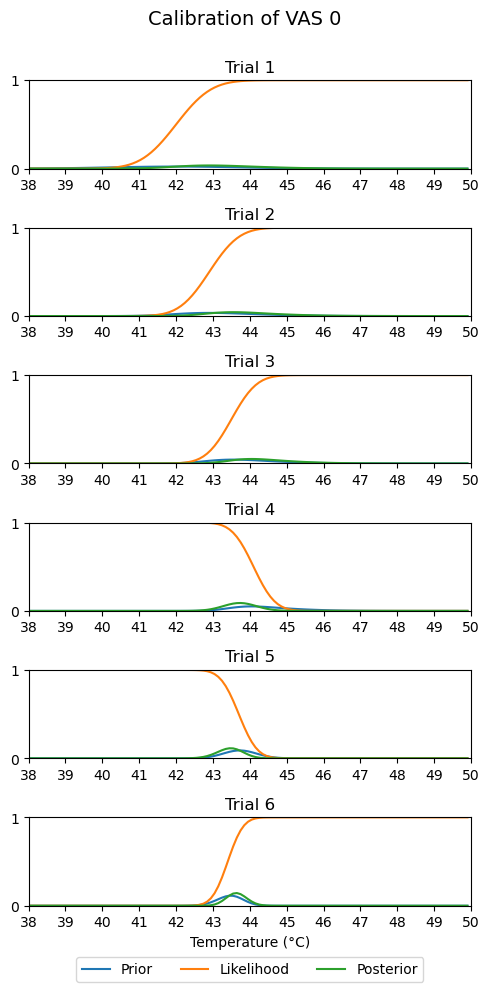

In [55]:
plot_trials(estimator_vas0, interactive=False)

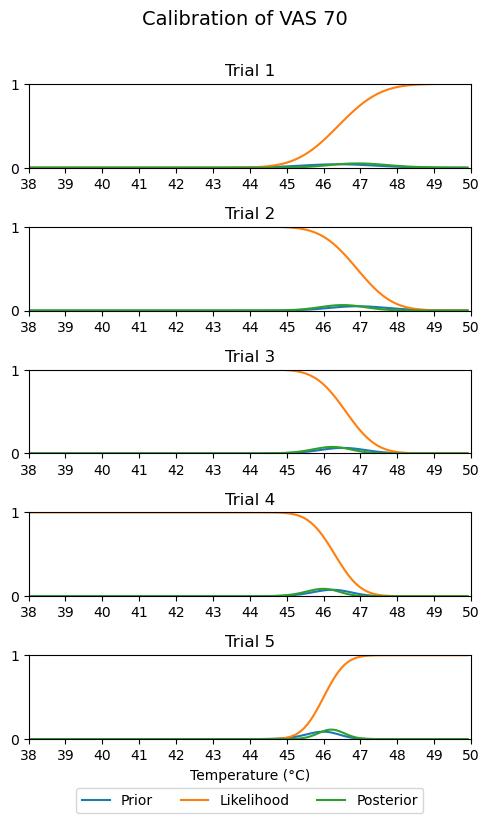

In [56]:
plot_trials(estimator_vas70, interactive=False)